In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import glob
import os

In [2]:
# Folders

current_dir = os.getcwd()

input_cal_folder = os.path.abspath(os.path.join(current_dir, "..", "raw", "participant_data"))
input_eda_folder = os.path.abspath(os.path.join(current_dir, "..", "raw", "EDA_DATA/formatted_EDA_data"))
input_hr_folder = os.path.abspath(os.path.join(current_dir, "..", "raw", "Fit_files"))


In [3]:
# EDA Data 
eda_pattern = os.path.join(input_eda_folder, "participant*.txt")
eda_data = glob.glob(eda_pattern)


In [4]:
"""  
Calibration data 
This is stored as a dictionary of participants, that contains a meta dataframe, a raw dataframe, and a dictionary of calibration dataframes 

  'participantx': {
      'meta': <DataFrame of meta.csv>,
      'raw': <DataFrame of raw.csv>,
      'calibrations': {
          'calibration0': <DataFrame>,
          'calibration1': <DataFrame>,
          ...
      }
  },


"""
all_participants = os.path.join(input_cal_folder, "participant*") 
cal_folders = glob.glob(all_participants)


participants_data = {}

for folder_path in cal_folders:
    participant_id = os.path.basename(folder_path)

    meta_path = os.path.join(folder_path, "meta.csv")
    raw_path = os.path.join(folder_path, "raw.csv")
    
    calibration_files = glob.glob(os.path.join(folder_path, "calibration*.csv"))
    
    meta_df = pd.read_csv(meta_path, header=None, names=["timestamp", "partID", "age-range", "gender", "temperature", "hand_roughness"]) if os.path.exists(meta_path) else None
    raw_df = pd.read_csv(raw_path, header=None, names=["timestamp", "VOLT", "PW", "PWI", "PPB", "FREQ", "calibration_counter"]) if os.path.exists(raw_path) else None

    calibration_dfs = {}
    for cal_file in calibration_files:
        cal_name = os.path.splitext(os.path.basename(cal_file))[0]
        calibration_dfs[cal_name] = pd.read_csv(cal_file, header=None, names=["timestamp", "VOLT", "PW", "PWI", "PPB", "FREQ"])
    
    participants_data[participant_id] = {
        'meta': meta_df,
        'raw': raw_df,
        'calibrations': calibration_dfs
    }


In [5]:
data_rows_time = []

for participant, pdata in participants_data.items():
    calibrations = pdata.get('calibrations')
    if not calibrations:
        continue
    for cal_name, cal_df in calibrations.items():
        if len(cal_df) < 2:
            continue
        min_val = cal_df.iloc[0]['VOLT']
        max_val = cal_df.iloc[1]['VOLT']
        time_min = cal_df.iloc[0]['timestamp']
        time_max = cal_df.iloc[1]['timestamp']
        cal_num = int(cal_name.replace("calibration", ""))
        
        data_rows_time.append({'participant_id': participant, 'calibration': cal_num, 'timestamp': time_min, 'voltage_type': 'min', 'VOLT': min_val})
        data_rows_time.append({'participant_id': participant, 'calibration': cal_num, 'timestamp': time_max,'voltage_type': 'max', 'VOLT': max_val})

df_calib_time = pd.DataFrame(data_rows_time)

In [6]:
eda_data_dir = {}
for file in eda_data:
    part_ID = os.path.splitext(os.path.basename(file))[0]
    eda_df = pd.read_csv(file, header=None, names=["timestamp", "EDA"])
    data = eda_df["EDA"]
    eda_data_dir[part_ID] = eda_df

combined_eda_df = pd.concat(eda_data_dir, names=['participant_id']).reset_index(level=0)
print(combined_eda_df.head())

  participant_id     timestamp       EDA
0   participant9  1.742832e+09  4.350586
1   participant9  1.742832e+09  4.350586
2   participant9  1.742832e+09  4.350586
3   participant9  1.742832e+09  4.350586
4   participant9  1.742832e+09  4.350586


In [7]:
# # Kernal smoothing function - taken from https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/time-series-analysis/Smoothing/Kernel-smoothing/index.html 

# def kernel_smoothing(y, x, sigma):
#     smoothed_vals = np.zeros(y.shape)
#     for i, x_position in enumerate(x):
#         kernel_weights = np.exp(-((x - x_position) ** 2) / (2 * sigma**2))
#         kernel_weights = kernel_weights / sum(kernel_weights)
#         smoothed_vals[i] = np.sum(y * kernel_weights)

#     return smoothed_vals


# y = combined_eda_df['participant9'][combined_eda_df['EDA']].values
# x = combined_eda_df['timestamp'].values.astype(np.int64) // 10**9 

# sigma = 20000 #.

# # smoothed_eda = kernel_smoothing(y, x, sigma)
# # print(smoothed_eda)

# print(y)


In [8]:
# EDA change percent over time - 

combined_eda_df['EDA_change_percent'] = combined_eda_df.groupby('participant_id')['EDA'].pct_change() * 100 
combined_eda_df.fillna(0, inplace=True)

combined_eda_df.head()

,participant_id,timestamp,EDA,EDA_change_percent
0,participant9,1.742832e+09,4.350586,0.0
1,participant9,1.742832e+09,4.350586,0.0
2,participant9,1.742832e+09,4.350586,0.0
3,participant9,1.742832e+09,4.350586,0.0
4,participant9,1.742832e+09,4.350586,0.0


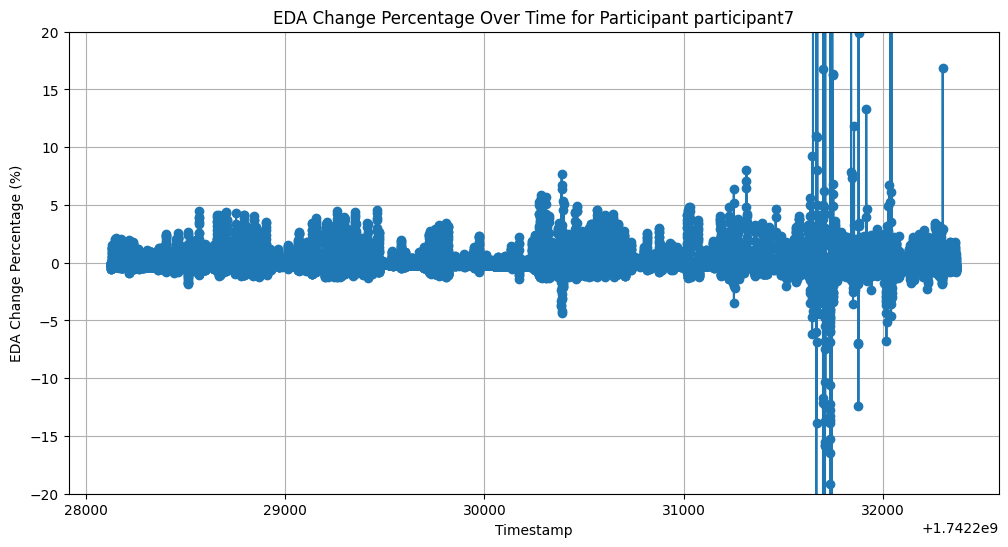

In [9]:
participant_id_to_plot = 'participant7'  

participant_data = combined_eda_df[combined_eda_df['participant_id'] == participant_id_to_plot]

plt.figure(figsize=(12, 6))
plt.plot(participant_data['timestamp'], participant_data['EDA_change_percent'], marker='o', linestyle='-')
plt.title(f'EDA Change Percentage Over Time for Participant {participant_id_to_plot}')
plt.xlabel('Timestamp')
plt.ylabel('EDA Change Percentage (%)')
plt.ylim(-20, 20)
plt.grid(True)
plt.show()

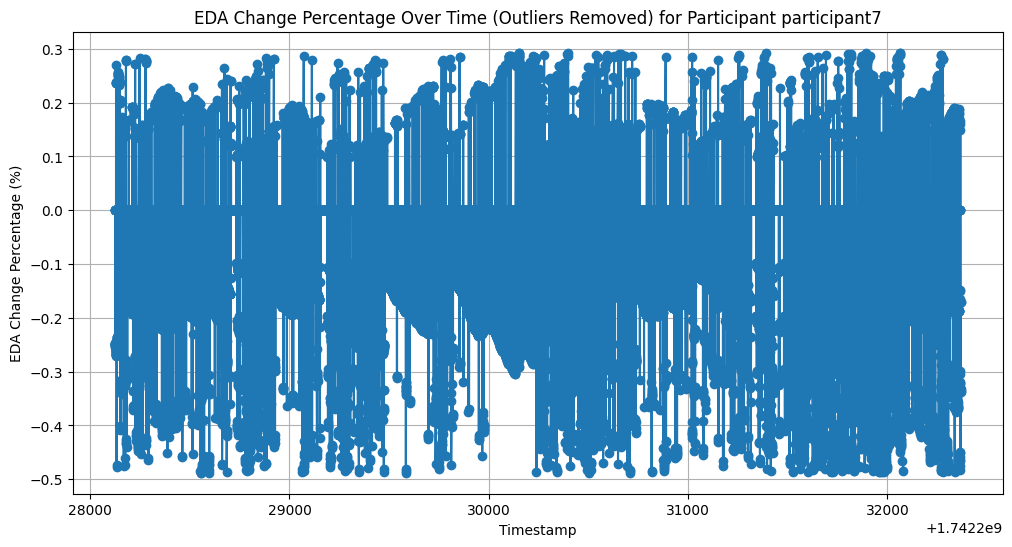

In [10]:
participant_data = combined_eda_df[combined_eda_df['participant_id'] == participant_id_to_plot].copy()

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

participant_data_filtered = remove_outliers_iqr(participant_data, 'EDA_change_percent')

plt.figure(figsize=(12, 6))
plt.plot(participant_data_filtered['timestamp'], participant_data_filtered['EDA_change_percent'], marker='o', linestyle='-')
plt.title(f'EDA Change Percentage Over Time (Outliers Removed) for Participant {participant_id_to_plot}')
plt.xlabel('Timestamp')
plt.ylabel('EDA Change Percentage (%)')
plt.grid(True)
plt.show()

In [11]:
results = []
# print(df_calib_time.head())
# print(combined_eda_df.head())

for participant_id in df_calib_time['participant_id'].unique():
    participant_calib = df_calib_time[df_calib_time['participant_id'] == participant_id]
    participant_eda = combined_eda_df[combined_eda_df['participant_id'] == participant_id]

    if not participant_calib.empty:
        min_timestamp = participant_calib['timestamp'].min()
        max_timestamp = participant_calib['timestamp'].max()

        filtered_eda = participant_eda[
            (participant_eda['timestamp'] >= min_timestamp) &
            (participant_eda['timestamp'] <= max_timestamp)
        ]

        results.append(filtered_eda)

eda_cal_time_df = pd.concat(results, ignore_index=True)
print(eda_cal_time_df.head())

  participant_id     timestamp        EDA  EDA_change_percent
0   participant7  1.742229e+09  16.005859                 0.0
1   participant7  1.742229e+09  16.005859                 0.0
2   participant7  1.742229e+09  16.005859                 0.0
3   participant7  1.742229e+09  16.005859                 0.0
4   participant7  1.742229e+09  16.005859                 0.0


In [15]:
output_folder = os.path.abspath(os.path.join(current_dir, "..", "processed", "graphs_EDA_cal_time"))

for participant_id in df_calib_time['participant_id'].unique():
    participant_calib = df_calib_time[df_calib_time['participant_id'] == participant_id]


    participant_eda = eda_cal_time_df[eda_cal_time_df['participant_id'] == participant_id]

    if participant_eda.empty:
        print(f"No EDA data found for participant: {participant_id}")
        continue

    eda_start = participant_eda['timestamp'].min()
    participant_eda['time_sec'] = participant_eda['timestamp'] - eda_start
    participant_eda['time_min'] = participant_eda['time_sec'] / 60


    participant_calib['time_sec'] = participant_calib['timestamp'] - eda_start
    participant_calib['time_min'] = participant_calib['time_sec'] / 60
    
    plt.figure(figsize=(20, 6))
    plt.plot(participant_eda['time_min'], participant_eda['EDA'], label='Sensor Reading', color='blue')
    plt.xlabel('Time minutes')
    plt.ylabel('Sensor Value in MicroSiemens (uS), calibration points in (V)')
    plt.ylim(0, 30)
    plt.title(f'EDA measurements over time for {participant_id} with calibration points')

    legend_labels = set()
    for (voltage_type, calibration), group in participant_calib.groupby(['voltage_type', 'calibration']):
        if voltage_type == 'min':
            marker = '^'
            color = 'red'
        else:
            marker = 'v'
            color = 'green'

        plt.scatter(group['time_min'], group['VOLT'], label=f'Calibration {voltage_type}', marker=marker, s=100, color=color)

        for index, row in group.iterrows():
            plt.text(row['time_min'] + 0.1, row['VOLT'] + 0.1, f"{calibration}", fontsize=9, color='black')

    plt.legend()
    plt.tight_layout()


    output_graph = os.path.join(output_folder, f'{participant_id}_EDA.png')
    plt.savefig(output_graph)
    plt.close()

/var/folders/sx/2dh9pxh144d_gh7jl6j_d1tr0000gn/T/ipykernel_40960/851597647.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_eda['time_sec'] = participant_eda['timestamp'] - eda_start
/var/folders/sx/2dh9pxh144d_gh7jl6j_d1tr0000gn/T/ipykernel_40960/851597647.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_eda['time_min'] = participant_eda['time_sec'] / 60
/var/folders/sx/2dh9pxh144d_gh7jl6j_d1tr0000gn/T/ipykernel_40960/851597647.py:18: SettingWithCopyWarning: 
A value is tryi

No EDA data found for participant: participant14


/var/folders/sx/2dh9pxh144d_gh7jl6j_d1tr0000gn/T/ipykernel_40960/851597647.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_eda['time_sec'] = participant_eda['timestamp'] - eda_start
/var/folders/sx/2dh9pxh144d_gh7jl6j_d1tr0000gn/T/ipykernel_40960/851597647.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participant_eda['time_min'] = participant_eda['time_sec'] / 60
/var/folders/sx/2dh9pxh144d_gh7jl6j_d1tr0000gn/T/ipykernel_40960/851597647.py:18: SettingWithCopyWarning: 
A value is tryi

In [13]:
# remove participants 2 and 3 as their calibration data is occurs before the EDA data
eda_time_trimmed_df = eda_cal_time_df.copy()
eda_time_trimmed_df = eda_time_trimmed_df[~eda_time_trimmed_df['participant_id'].isin(['participant2', 'participant3', 'participant14', 'participant7'])]

cal_data_trimmed_df = df_calib_time.copy()
cal_data_trimmed_df = cal_data_trimmed_df[~cal_data_trimmed_df['participant_id'].isin(['participant2', 'participant3', 'participant14', 'participant7'])]

In [14]:
eda_cal_results = []

mapped_eda_df = eda_time_trimmed_df.copy()
eda_cal_df = cal_data_trimmed_df.copy()

for participant_id in cal_data_trimmed_df['participant_id'].unique():
    for i in range(0,3):
        participant_cal = cal_data_trimmed_df[
            (cal_data_trimmed_df['participant_id'] == participant_id) & 
            (cal_data_trimmed_df['calibration'] == i)
        ]
        if participant_cal.empty:
            continue
        
        timestamp_cal_min = participant_cal[participant_cal['voltage_type'] == 'min']['timestamp'].iloc[0]
        timestamp_cal_max = participant_cal[participant_cal['voltage_type'] == 'max']['timestamp'].iloc[0]
        
        mask = (
            (mapped_eda_df['participant_id'] == participant_id) & 
            (mapped_eda_df['timestamp'] >= timestamp_cal_min) & 
            (mapped_eda_df['timestamp'] <= timestamp_cal_max)
        )
        
        mean_eda_timestamp = mapped_eda_df.loc[mask, 'EDA'].mean()
        #print(f' participant_id: {participant_id}, calibration: {i}, mean EDA: {mean_eda_timestamp}')
        eda_cal_results.append({
            'participant_id': participant_id,
            'calibration': i,
            'EDA_mean_cal': mean_eda_timestamp
        })


eda_cal_df = pd.DataFrame(eda_cal_results)


print(eda_cal_df.head())
eda_cal_df = pd.merge(cal_data_trimmed_df, eda_cal_df, on=['participant_id', 'calibration'], how='left')

print(eda_cal_df.head(10))



  participant_id  calibration  EDA_mean_cal
0   participant9            0      8.943406
1   participant9            1      8.676833
2   participant9            2      8.456590
3   participant8            0      8.914487
4   participant8            1      9.402695
  participant_id  calibration     timestamp voltage_type   VOLT  EDA_mean_cal
0   participant9            1  1.742835e+09          min   3.72      8.676833
1   participant9            1  1.742835e+09          max  12.00      8.676833
2   participant9            0  1.742834e+09          min   3.76      8.943406
3   participant9            0  1.742834e+09          max   9.00      8.943406
4   participant9            2  1.742835e+09          min   3.73      8.456590
5   participant9            2  1.742835e+09          max  10.50      8.456590
6   participant9            3  1.742836e+09          min   3.93           NaN
7   participant9            3  1.742836e+09          max  15.00           NaN
8   participant8            1  1.7